# 1. Exploring 1-band model

## Set up

Libraries used

In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

The entire model class (for reference)

In [2]:
class Net(nn.Module):
    def __init__(self, upscale_factor):
        super(Net, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

    def _initialize_weights(self):
        init.orthogonal(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal(self.conv4.weight)

Creating an 'image' to test the model architecture with; this is a 500x500 image with 1 color band (like elevation), and I'm going to try to increase it to a 1500x1500 image (similar to the 30m -> 10m problem)

In [3]:
testing = np.zeros((1, 1, 500, 500))
testing = torch.from_numpy(testing)
testing = Variable(testing)
testing = testing.float()
testing

Variable containing:
( 0 , 0 ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
[torch.FloatTensor of size 1x1x500x500]

### The beginning image

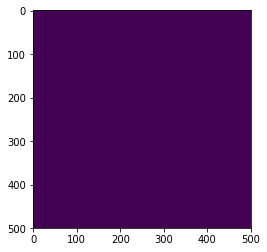

In [4]:
plt.imshow(testing.data.numpy().squeeze())

Testing the ReLU layer

In [5]:
relu_layer = nn.ReLU()
relu_output = relu_layer(testing)
relu_output

Variable containing:
( 0 , 0 ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
[torch.FloatTensor of size 1x1x500x500]

Testing the convolution layers

In [6]:
upscale_factor = 3

c1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
c2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
c3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
c4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))

conv_output = c4(c3(c2(c1(relu_output))))
conv_output

Variable containing:
( 0 , 0 ,.,.) = 
  0.0191  0.0193  0.0274  ...   0.0275  0.0261  0.0328
  0.0162  0.0075  0.0142  ...   0.0177  0.0252  0.0179
  0.0084  0.0003  0.0066  ...   0.0084  0.0114  0.0110
           ...             ⋱             ...          
  0.0123 -0.0027  0.0023  ...   0.0054  0.0085  0.0053
  0.0132  0.0041  0.0070  ...   0.0107  0.0149  0.0056
  0.0053 -0.0058 -0.0089  ...  -0.0089 -0.0115 -0.0130

( 0 , 1 ,.,.) = 
 -0.0090 -0.0069 -0.0167  ...  -0.0232 -0.0234 -0.0086
 -0.0211 -0.0189 -0.0350  ...  -0.0393 -0.0413 -0.0184
 -0.0198 -0.0163 -0.0340  ...  -0.0416 -0.0426 -0.0183
           ...             ⋱             ...          
 -0.0134 -0.0118 -0.0321  ...  -0.0378 -0.0431 -0.0199
 -0.0194 -0.0231 -0.0427  ...  -0.0439 -0.0476 -0.0236
 -0.0055 -0.0070 -0.0186  ...  -0.0221 -0.0271 -0.0231

( 0 , 2 ,.,.) = 
 -0.0513 -0.0621 -0.0576  ...  -0.0541 -0.0556 -0.0463
 -0.0505 -0.0628 -0.0624  ...  -0.0644 -0.0643 -0.0523
 -0.0452 -0.0549 -0.0529  ...  -0.0554 -0.0600

Testing the pixel shuffle layer

In [7]:
shuffle_layer = nn.PixelShuffle(upscale_factor)

shuffle_output = shuffle_layer(conv_output)
shuffle_output

Variable containing:
( 0  , 0  ,.,.) = 
  0.0191 -0.0090 -0.0513  ...   0.0328 -0.0086 -0.0463
  0.0155  0.0184 -0.0708  ...  -0.0172  0.0431 -0.0899
 -0.0188 -0.0531 -0.0100  ...  -0.0289 -0.0599 -0.0086
           ...             ⋱             ...          
  0.0053 -0.0055 -0.0487  ...  -0.0130 -0.0231 -0.0577
  0.0362  0.0307 -0.0536  ...   0.0068  0.0425 -0.0885
 -0.0057 -0.0663  0.0062  ...  -0.0174 -0.0518 -0.0192
[torch.FloatTensor of size 1x1x1500x1500]

Testing the entire forward pass

In [8]:
forward_pass = shuffle_layer(
    c4(
        relu_layer(
            c3(
                relu_layer(
                    c2(
                        relu_layer(
                            c1(
                                testing))))))))

forward_pass

Variable containing:
( 0  , 0  ,.,.) = 
1.00000e-02 *
  1.8208 -1.0245 -4.8748  ...   2.3263 -1.7004 -4.8196
  1.5000  2.7008 -4.8481  ...   0.7227  3.0765 -5.2113
 -0.3702 -5.5889 -1.2401  ...  -1.3684 -5.6257 -1.2721
           ...             ⋱             ...          
  0.0611 -0.0270 -6.0078  ...   0.9214 -0.9115 -5.9274
  1.3240  2.4525 -5.4088  ...   1.0712  3.1588 -4.6212
  0.0109 -5.8816 -0.7942  ...  -0.7350 -5.1021 -1.8627
[torch.FloatTensor of size 1x1x1500x1500]

### The output image

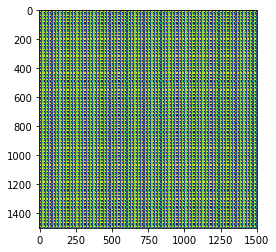

In [9]:
plt.imshow(forward_pass.data.numpy().squeeze())

# 2. Variable number of bands?

Specifying the number of bands

In [10]:
NUMBER_OF_BANDS = 4

Creating a testing input with that many bands

In [11]:
testing = np.zeros((1, NUMBER_OF_BANDS, 500, 500))
testing = torch.from_numpy(testing)
testing = Variable(testing)
testing = testing.float()
print(testing.size())
testing

torch.Size([1, 4, 500, 500])


Variable containing:
( 0 , 0 ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

( 0 , 1 ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

( 0 , 2 ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

( 0 , 3 ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
[torch.FloatTensor of size 1x4x500x500]

Tweaking the model

In [12]:
class Net(nn.Module):
    def __init__(self, upscale_factor):
        super(Net, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(NUMBER_OF_BANDS, 64, (5, 5), (1, 1), (2, 2))      # Here 
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, ((NUMBER_OF_BANDS) * (upscale_factor ** 2)),  # And here
                               (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

    def _initialize_weights(self):
        init.orthogonal(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal(self.conv4.weight)
        
model = Net(upscale_factor = 3)

The output!

In [13]:
output = model(testing)
print(output.size())
output

torch.Size([1, 4, 1500, 1500])


Variable containing:
( 0  , 0  ,.,.) = 
 -0.0494  0.0230 -0.0100  ...  -0.0182  0.0264 -0.0231
  0.0144  0.0137  0.0020  ...   0.0031 -0.0364 -0.0438
 -0.1033  0.0638 -0.0492  ...  -0.0345  0.0401 -0.0343
           ...             ⋱             ...          
 -0.0315  0.0545  0.0385  ...  -0.0462  0.0263  0.0040
  0.0097  0.0209  0.0366  ...   0.0263 -0.0566  0.0219
 -0.0538  0.0523  0.0287  ...   0.0179  0.0564 -0.0311

( 0  , 1  ,.,.) = 
 -0.0353  0.0024  0.0561  ...   0.0113  0.0395  0.0382
 -0.0193  0.0069  0.0789  ...  -0.0152  0.0120  0.0529
 -0.0419 -0.1091 -0.0087  ...  -0.0342  0.0029  0.0087
           ...             ⋱             ...          
  0.0513 -0.0107  0.0729  ...  -0.0285  0.0338  0.0652
  0.0363 -0.0038  0.0628  ...   0.0105  0.0136  0.0335
 -0.0104 -0.0346 -0.0150  ...  -0.0297 -0.0657 -0.0023

( 0  , 2  ,.,.) = 
  0.0203 -0.0092  0.0126  ...   0.0386  0.0132 -0.0038
 -0.0731 -0.0362  0.0523  ...  -0.0176  0.0091  0.0580
 -0.0165 -0.0369  0.0575  ...  -0.0221 -